# API In-Class Assignment
---
Jan. 14, 2026 <br>
## Team: Clouds

# Dependencies

In [24]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO # suggested by ChatGPT

# Data Access

In [25]:
# Define API URL
url = "https://waterservices.usgs.gov/nwis/iv/?sites=12451000&agencyCd=USGS&startDT=2025-12-10T00:00:00.000-08:00&endDT=2025-12-13T23:59:59.999-08:00&parameterCd=00065&format=rdb"

# Download data
response = requests.get(url)
response.raise_for_status()  # Raise an error if the request failed

# Open Data
quick look at raw data to see what adjustments should be made

In [38]:
# suggested by ChatGPT for USGS .rdb files (legacy file type)
df = pd.read_csv(
    StringIO(response.text),
    sep="\t",
    comment="#",
    skiprows=[1]   # skip the format-spec line
)

print(df.head())
print(df.columns)



  agency_cd   site_no          datetime tz_cd 151780_00065 151780_00065_cd
0        5s       15s               20d    6s          14n             10s
1      USGS  12451000  2025-12-10 00:00   PST        21.00               P
2      USGS  12451000  2025-12-10 00:15   PST        20.99               P
3      USGS  12451000  2025-12-10 00:30   PST        20.98               P
4      USGS  12451000  2025-12-10 00:45   PST        21.00               P
Index(['agency_cd', 'site_no', 'datetime', 'tz_cd', '151780_00065',
       '151780_00065_cd'],
      dtype='object')


# Info on Data
for info on the rdb data format readh this: https://waterdata.usgs.gov/nwis/?tab_delimited_format_info <br>
00065 is the parameter code for daily data means it is the Gage height, feet (mean) <br>
_cd means "collecting data" <br>
151780 may be the sensor code. Since 00065 is already the parameter code <br>
the P in the last column likely stands for "provisional" indicating the data may be subject to revision <br>

# Clean Data for Analysis
with help from ChatGPT

In [39]:
df = df.iloc[1:].reset_index(drop=True) # ChatGPT recommends dropping this format spec row from the dataframe (df) 

df["datetime"] = pd.to_datetime(df["datetime"]) # ChatGPT recommends converting datetime to numeric values

df["151780_00065"] = pd.to_numeric(df["151780_00065"], errors="coerce") # ChatGPT recommends converting stage (gage height) values to numeric values

df = df.rename(columns={"151780_00065": "Gage Height (ft)"}) # rename column title to something more easily understood

# check data again
print(df.head())
print(df.columns)


  agency_cd   site_no            datetime tz_cd  Gage Height (ft)  \
0      USGS  12451000 2025-12-10 00:00:00   PST             21.00   
1      USGS  12451000 2025-12-10 00:15:00   PST             20.99   
2      USGS  12451000 2025-12-10 00:30:00   PST             20.98   
3      USGS  12451000 2025-12-10 00:45:00   PST             21.00   
4      USGS  12451000 2025-12-10 01:00:00   PST             21.00   

  151780_00065_cd  
0               P  
1               P  
2               P  
3               P  
4               P  
Index(['agency_cd', 'site_no', 'datetime', 'tz_cd', 'Gage Height (ft)',
       '151780_00065_cd'],
      dtype='object')


# Plot Data

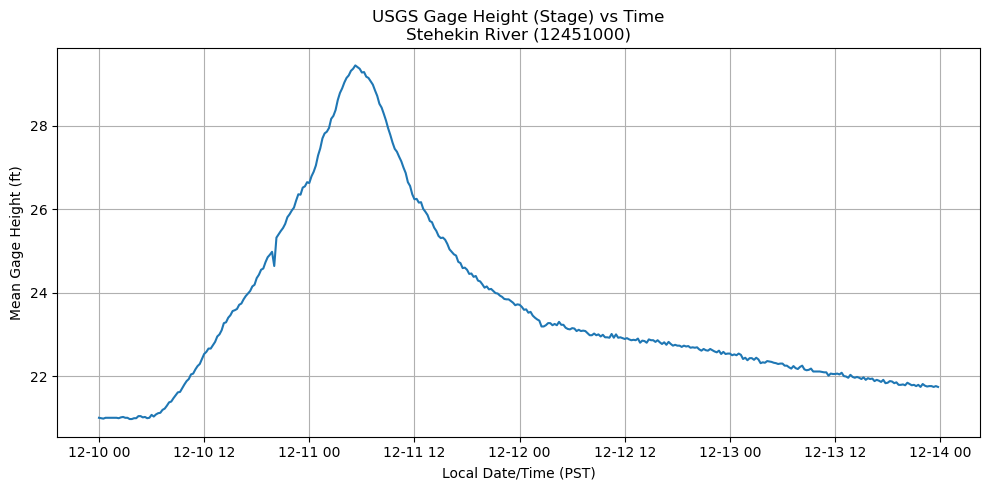

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(df['datetime'], df['Gage Height (ft)'])
plt.xlabel('Local Date/Time (PST)')
plt.ylabel('Mean Gage Height (ft)')
plt.title("USGS Gage Height (Stage) vs Time\nStehekin River (12451000)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
##Sofia's try at URL

url = 'https://waterservices.usgs.gov/nwis/iv/?format=rdb&sites=12451000&parameterCd=00060&startDT=2025-12-01&endDT=2025-12-31'

# Download data
response = requests.get(url)
response.raise_for_status()  # Raise an error if the request failed

# Split into lines and filter out comments
lines = response.text.split('\n')
data_lines = [line for line in lines if not line.startswith('#')]

# The first line is headers, second line is data types (skip it), rest is data
header = data_lines[0]
data = '\n'.join([header] + data_lines[2:])  # Skip the format descriptor row

# Read into DataFrame
stream_data = pd.read_csv(
    StringIO(data),
    sep="\t",
    parse_dates=["datetime"]
)

# Streamflow column has weird name, this code finds it based on API
# Find the streamflow column (parameter code 00060, without _cd suffix)
streamflow_col = [col for col in stream_data.columns if '00060' in col and not col.endswith('_cd')][0]

print(f"Streamflow column: {streamflow_col}")
print(f"Units: cubic feet per second (cfs)")

# Rename for clarity
stream_data = stream_data.rename(columns={streamflow_col: 'discharge_cfs'})

# Removing weird and unnecesary column
stream_data = stream_data.drop(columns=['151779_00060_cd'])

stream_data.head()

Streamflow column: 151779_00060
Units: cubic feet per second (cfs)


,agency_cd,site_no,datetime,tz_cd,discharge_cfs
0,USGS,12451000,2025-12-01 00:00:00,PST,732
1,USGS,12451000,2025-12-01 00:15:00,PST,732
2,USGS,12451000,2025-12-01 00:30:00,PST,716
3,USGS,12451000,2025-12-01 00:45:00,PST,724
4,USGS,12451000,2025-12-01 01:00:00,PST,708


In [16]:
##Sofia: Using JSON format to get metadata

# Use JSON format to get metadata
url_json = 'https://waterservices.usgs.gov/nwis/iv/?format=json&sites=12451000&parameterCd=00060&startDT=2025-12-01&endDT=2025-12-31'

response = requests.get(url_json)
data = response.json()

# Extract units from the metadata
time_series = data['value']['timeSeries'][0]
variable = time_series['variable']

print(f"Parameter: {variable['variableName']}")
print(f"Description: {variable['variableDescription']}")
print(f"Unit: {variable['unit']['unitCode']}")

Parameter: Streamflow, ft&#179;/s
Description: Discharge, cubic feet per second
Unit: ft3/s


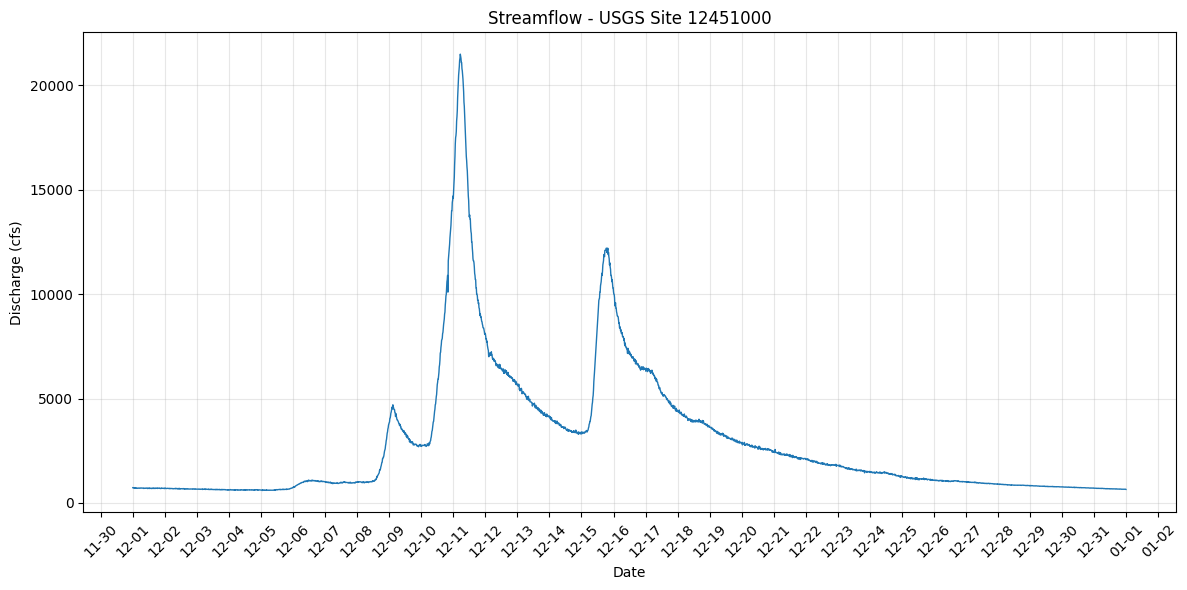

In [22]:
# Sofia: Making plot for streamgauge data

plt.figure(figsize=(12, 6))
plt.plot(stream_data['datetime'], stream_data['discharge_cfs'], linewidth=1)

plt.xlabel('Date')
plt.ylabel('Discharge (cfs)')
plt.title('Streamflow - USGS Site 12451000')

# Set major gridlines to daily
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()